## μNCA: Texture Generation with Ultra-Compact Neural Cellular Automata

*We strongly encourage using [this link](https://colab.research.google.com/github/google-research/self-organising-systems/blob/master/notebooks/%CE%BCNCA_jax.ipynb) to open the notebook in Colaboratory.*

This notebook contains code to reproduce experiments and figures for ["μNCA: Texture Generation with Ultra-Compact Neural Cellular Automata"](https://arxiv.org/abs/2111.13545) article.

Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
#@title identify accelerator
accelerator = "cpu"

# check for GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if "failed" not in gpu_info:
  accelerator = "gpu"

# check for TPU
# hopefully deprecated step in future
import jax.tools.colab_tpu
try:
  jax.tools.colab_tpu.setup_tpu()
  accelerator = "tpu"
except:
  pass

print("jax using accelerator: %s, recommended: tpu" % accelerator)

jax using accelerator: tpu, recommended: tpu


In [ ]:
#@title imports
import os
import io
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import base64
import zipfile
import json
import requests
import matplotlib.pylab as pl
!pip install -q --progress-bar off mediapy
import mediapy as media
import numpy as np
import glob
import requests
import random as pyrandom
from concurrent import futures
from IPython.display import display
from functools import partial
from scipy.ndimage import rotate
import matplotlib.pyplot as pl
!pip install -q --progress-bar off ott-jax
from ott.geometry import pointcloud
from ott.core import sinkhorn
from ott.tools import transport
from ott.tools import sinkhorn_divergence
from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange

In [ ]:
#@title helper functions 
def imread(url, max_size=None, fixed_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if fixed_size is not None:
    img = PIL.ImageOps.fit(img, (fixed_size, fixed_size), PIL.Image.ANTIALIAS) 
  if mode is not None:
    img = img.convert(mode)
  img = jnp.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

def pad_repeat(x, pad):
  x = jnp.concatenate([x[:, -pad:, :, :], x, x[:, :pad, :, :]], 1)
  x = jnp.concatenate([x[:, :, -pad:, :], x, x[:, :, :pad, :]], 2)
  return x

def to_rgb(x):
  return x[..., :3] + 0.5

In [ ]:
#@title import jax
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap, pmap, lax, nn
from jax.example_libraries import optimizers 

In [ ]:
# helper: normalise backward-flowing gradients for a tensor
@jax.custom_vjp
def batch_normalise_grad(x):
  return x 

def ng_fwd(x):
  return batch_normalise_grad(x), None 

def ng_bwd(res, g):
  # vmap over batch axis
  return jax.vmap(lambda g: (g/(jnp.linalg.norm(g)+1e-12),))(g)

batch_normalise_grad.defvjp(ng_fwd, ng_bwd)

In [ ]:
# patch extraction, OTT loss
PYRAMID_TYPE = "UNSHARP" # {"BOXBLUR", "GAUSSIAN", "LAPLACIAN", "UNSHARP"}
NUM_LEVELS = 5
K_SIZE = 5

def _gaussblur(x, stride=1):
  v = jax.scipy.stats.norm.pdf(jnp.array([3., 2., 1., 0., 1., 2., 3.]))
  v = v/jnp.sum(v)
  gk = jnp.outer(v, v)
  x = jnp.pad(x, ((0,0), (3,3), (3,3), (0,0)), mode='reflect')
  return lax.conv_general_dilated(x,
                                  jnp.repeat(gk[..., None, None], x.shape[-1], axis=-1), (stride, stride),
                                  padding='VALID', 
                                  feature_group_count=x.shape[-1],
                                  dimension_numbers=('NHWC', 'HWIO', 'NHWC'))

def _pool(x, mode, kernel=3, stride=2):
  if mode == 'BOXBLUR':
    return lax.reduce_window(x, 0., lax.add, (1, kernel, kernel, 1),
                              (1, stride, stride, 1), 'VALID') / kernel**2
  elif mode == 'GAUSSIAN':
    return _gaussblur(x, stride=2)
  elif mode == 'LAPLACIAN':
    blurred = _gaussblur(x) 
    diff = x - blurred
    blurred_subsampled = blurred[:, ::2, ::2, :]
    return diff, blurred_subsampled
  elif mode == 'UNSHARP':
    blurred = _gaussblur(x) 
    unsharp = x + (x - blurred) * 2.0 
    blurred_subsampled = blurred[:, ::2, ::2, :]
    return unsharp, blurred_subsampled

def _unfold(x, kernel=3, stride=1):
  unfolded = lax.conv_general_dilated_patches(x, (kernel, kernel), 
          (stride, stride), 'VALID', dimension_numbers=('NHWC', 'OIHW', 'NHWC'))
  return jnp.reshape(unfolded, (unfolded.shape[0], -1, unfolded.shape[3]))

def ott_loss(key, xs, ys):
  def sinkhorn_loss(x, y): 
    geom = pointcloud.PointCloud(x, y)
    return sinkhorn.sinkhorn(geom, implicit_differentiation=True).reg_ot_cost

  # vmap batch dimension only for x
  batch_sinkhorn_loss = vmap(sinkhorn_loss, (0, None)) 

  loss = 0.0
  for x, y in zip(xs, ys):
    key, skey = random.split(key)
    x = subsample(x, 2048, skey)
    key, skey = random.split(key)
    y = subsample(y, 2048, skey, batched=False) 
    loss += jnp.sum(batch_sinkhorn_loss(x, y))

  return loss

@partial(jit, static_argnums=(1, 2, 3))
def calc_levels(img, ksize=K_SIZE, leveln=NUM_LEVELS, mode=PYRAMID_TYPE):
  levels = []
  for i in range(leveln):
    if mode in ['LAPLACIAN', 'UNSHARP']: 
      if i == 0:
        subsample = img
      if i == (leveln - 1):
        img = subsample        
      else:
        img, subsample = _pool(subsample, mode)
    elif mode in ['BOXBLUR', 'GAUSSIAN']:
      if i > 0:
        img = _pool(img, mode)
    else:
      raise Exception("invalid pyramid type")
    win = _unfold(img, ksize)
    levels.append(win)
  return levels

def subsample(x, n, key, batched=True):
  _subsample = (lambda x, skey: random.choice(skey, x, shape=(n,)))
  if batched:
    return jax.vmap(_subsample)(x, random.split(key, x.shape[0]))
  else: 
    return _subsample(x, key)

In [ ]:
# μNCA
CHN = 12 
USE_ABS = True
H = W = 128
FILTERS = ["L"] * 4 + ["Sx"] * 4 + ["Sy"] * 4

_kernels = {
    "L": jnp.array([[1.0, 2.0, 1.0], [2.0, -12, 2.0], [1.0, 2.0, 1.0]]),
    "Sx": jnp.array([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]]),
    "Sy": jnp.transpose(jnp.array([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]]))
}

_filters = jnp.stack([_kernels[id] for id in FILTERS], axis=-1)[..., None]

def init_params(key):
    params = {}
    key, skey = random.split(key)
    params["w"] = random.normal(skey, (4 * CHN, CHN)) * 1e-3
    key, skey = random.split(key)
    params["b"] = random.normal(skey, (CHN,)) * 1e-3
    return params

def ca_step(x, w, b, key):
  y = pad_repeat(x, 1)
  y = lax.conv_general_dilated(
      y,
      _filters, (1, 1),
      padding='VALID',
      feature_group_count=CHN,
      dimension_numbers=('NHWC', 'HWOI', 'NHWC'))
  y = jnp.concatenate([x, y], -1)

  if USE_ABS: 
    y = jnp.concatenate([y, jnp.abs(y)], -1)
  else:
    y = jnp.concatenate([nn.relu(y), -nn.relu(-y)], -1)

  y = jnp.einsum('ixyj, jk -> ixyk', y, w) + b[None, None, None, :]
  return x + y

In [ ]:
key = random.PRNGKey(0x5E1F059)
BATCH_SIZE = 4 
NUM_POOL = 128 # pool size per texture
ITER_LEN = 64 # iteration length 

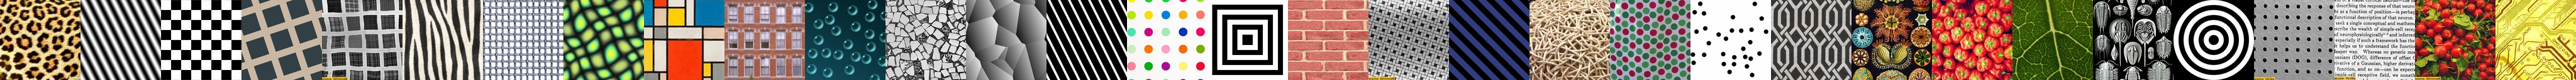

In [ ]:
!wget -q https://github.com/google-research/self-organising-systems/raw/master/assets/muNCA/textures.zip -O textures.zip
!unzip -o -q textures.zip
textures = [os.path.join(dirname, filename) for dirname, subdirs, filenames in os.walk("final_set") for filename in filenames]
pyrandom.shuffle(textures)
textures_vis = jnp.concatenate([imread(target, fixed_size=128, mode="RGB") for target in textures], axis=1)
imshow(textures_vis)

In [ ]:
@jit
def iterate_ca(key, ca_params, pool, inner_step):
  # take things from the pool
  key, skey = random.split(key)
  pool_idx = random.choice(skey, NUM_POOL, shape=(BATCH_SIZE,), replace=False)
  x = pool[pool_idx]

  # replace first entry every few steps 
  key, skey = random.split(key)
  seed = random.uniform(skey, (1, H, W, CHN)) - 0.5
  x = jnp.where(inner_step % 8 == 0, jnp.concatenate((seed, x[1:]), axis=0), x) 

  # iterate the NCA
  def body(_, carry):
    key, x = carry
    key, skey = random.split(key)
    x = ca_step(x, ca_params["w"], ca_params["b"], skey)
    x = batch_normalise_grad(x)
    return (key, x)
  
  key, x = lax.fori_loop(0, ITER_LEN, body, (key, x))
  
  # return things into the pool
  pool_idx = pool_idx[..., None] # quirk of scatter
  pool = lax.scatter(pool, pool_idx, x, lax.ScatterDimensionNumbers((1, 2, 3),(0,),(0,)), unique_indices=True)

  return x, pool, pool_idx

@jit
def loss_fn(ca_params, target_levels, pool, inner_step, key):
  key, skey = random.split(key)
  x, pool, pool_idx = iterate_ca(skey, ca_params, pool, inner_step)
  x_levels = calc_levels(to_rgb(x), mode=PYRAMID_TYPE)
  key, skey = random.split(key)
  loss = jnp.mean(ott_loss(skey, x_levels, target_levels))
  overflow_loss = jnp.sum(jnp.square((x - lax.clamp(-1.0, x, 1.0))))
  return loss + overflow_loss, (pool, pool_idx)

# execute num_inner_steps gradient steps
def get_steps_fn(get_params, opt_update):

  @jit
  def steps(key, step, num_inner_steps, opt_state, target_levels, pool):
    def body(inner_step, carry):
      key, value, opt_state, pool, _unused_pool_idx = carry
      key, skey = random.split(key)
      (value, (pool, pool_idx)), grads = jax.value_and_grad(loss_fn, has_aux=True)(get_params(opt_state), target_levels, pool, inner_step, skey)
      grads["w"] = grads["w"]/(jnp.linalg.norm(grads["w"], axis=(0,1))[None, None]+1e-12)
      grads["b"] = grads["b"]/(jnp.linalg.norm(grads["b"], axis=(0,))[None]+1e-12)
      opt_state = opt_update(inner_step, grads, opt_state)
      return (key, value, opt_state, pool, pool_idx)
    
    # needed to satisfy loop cond, much like init loss
    _unused_pool_idx = random.choice(skey, NUM_POOL, shape=(BATCH_SIZE,), replace=False)[..., None]
  
    key, value, opt_state, pool, pool_idx = lax.fori_loop(step, step+num_inner_steps, body, (key, 0.0, opt_state, pool, _unused_pool_idx))
  
    return value, opt_state, step+num_inner_steps, pool, pool_idx
    
  return steps

In [ ]:
def prepare_tex(key, target_img):
  key, skey = random.split(key)
  params = init_params(skey)
  key, skey = random.split(key)
  pool = random.uniform(skey, (NUM_POOL, H, W, CHN)) - 0.5
  target = calc_levels(target_img)
  target = [_target[0] for _target in target]
  return params, target, pool

step 8000 loss: 129.620178


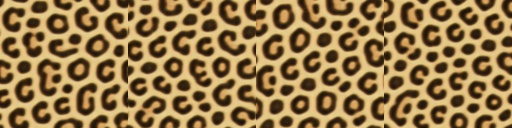

In [12]:
# train a single texture
target_img = imread(textures[0], fixed_size=128, mode="RGB")[None, ...]
key, skey = random.split(key)
params, target, pool = prepare_tex(key, target_img)
opt_init, opt_update, get_params = optimizers.adam(1e-3)
opt_state = opt_init(params)
steps_fn = get_steps_fn(get_params, opt_update)
step = 0
while step < 8000:
  key, skey = random.split(key)
  value, opt_state, step, pool, pool_idx = steps_fn(skey, step, 100, opt_state, target, pool)
  clear_output()
  print("step %i loss: %f"%(int(step), float(value)))
  imshow(to_rgb(jnp.hstack(pool[pool_idx[:, 0]])))

step 8000: 
tex 0 loss 131.139236


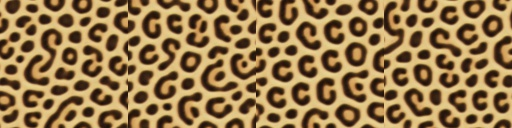

tex 1 loss 57.401073


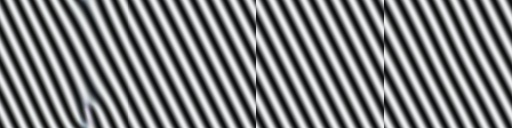

In [13]:
# train two textures at a time (no TPU parallelism)
target_textures = textures[0:2]
targets = jnp.array([imread(texture_path, fixed_size=128, mode="RGB")[None, ...] for texture_path in target_textures])
key, skey = random.split(key)
skeys = random.split(skey, 2)
opt_init, opt_update, get_params = optimizers.adam(1e-3)
vmap_params, vmap_target, vmap_pool = vmap(prepare_tex)(skeys, targets)
vmap_opt_state = vmap(opt_init)(vmap_params)
steps_fn = get_steps_fn(get_params, opt_update)
step = 0
while step < 8000:
  key, skey = random.split(key)
  skeys = random.split(skey, 2)
  vmap_value, vmap_opt_state, vmap_step, vmap_pool, vmap_pool_idx = vmap(steps_fn, (0, None, None, 0, 0, 0))(skeys, step, 100, vmap_opt_state, vmap_target, vmap_pool)
  step = vmap_step[0]
  clear_output()
  print("step %i: "%int(step))
  for tex_idx, (pool, pool_idx, loss) in enumerate(zip(vmap_pool, vmap_pool_idx, vmap_value)):
    print("tex %i loss %f" % (tex_idx, loss))
    imshow(to_rgb(jnp.hstack(pool[pool_idx[:, 0]])))

step 3900: 
tpu 0 loss 131.545166


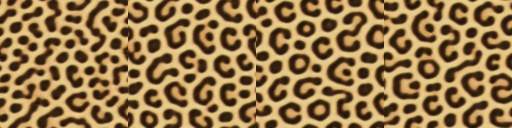

tpu 1 loss 62.347561


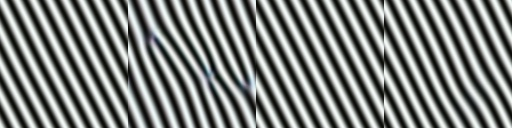

tpu 2 loss 209.571274


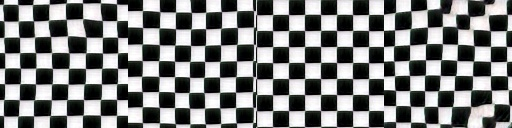

tpu 3 loss 44.889793


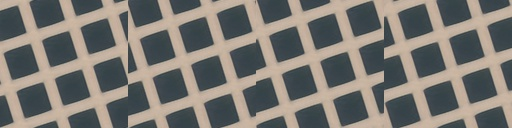

tpu 4 loss 91.408150


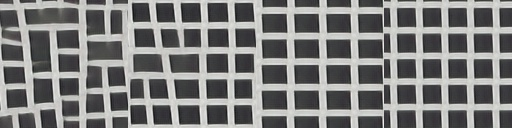

tpu 5 loss 93.482544


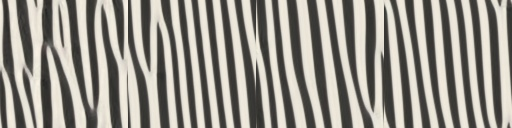

tpu 6 loss 52.657101


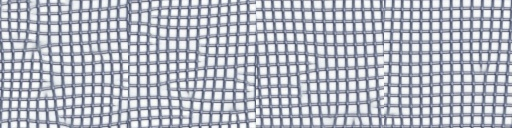

tpu 7 loss 63.482922


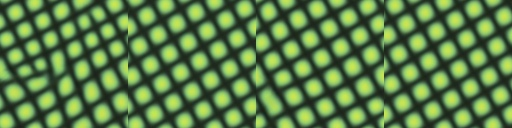

In [ ]:
# train one texture per TPU core
target_textures = textures[0:8]
targets = jnp.array([imread(texture_path, fixed_size=128, mode="RGB")[None, ...] for texture_path in target_textures])
key, skey = random.split(key)
skeys = random.split(skey, 8)
opt_init, opt_update, get_params = optimizers.adam(1e-3)
pmap_params, pmap_target, pmap_pool = pmap(prepare_tex)(skeys, targets)
pmap_opt_state = pmap(opt_init)(pmap_params)
steps_fn = get_steps_fn(get_params, opt_update)
step = 0
while step < 6000:
  key, skey = random.split(key)
  skeys = random.split(skey, 8)
  # pmap doesn't allow scalars in this case, so we bake them in
  steps_fn_wrapped = lambda skey, opt_state, target, pool: steps_fn(skey, step, 100, opt_state, target, pool)
  pmap_value, pmap_opt_state, pmap_step, pmap_pool, pmap_pool_idx = pmap(steps_fn_wrapped)(skeys, pmap_opt_state, pmap_target, pmap_pool)
  step = pmap_step[0]
  clear_output()
  print("step %i: "%int(step))
  for tex_idx, (pool, pool_idx, loss) in enumerate(zip(pmap_pool, pmap_pool_idx, pmap_value)):
    print("tpu %i loss %f" % (tex_idx, loss))
    imshow(to_rgb(jnp.hstack(pool[pool_idx[:, 0]])))

In [ ]:
# run this cell to generate video
x = random.uniform(key, (1,128,128,12)) - 0.5
pmap_params = get_params(pmap_opt_state) 
i = 3
frames = []
for _ in range(1000):
  x = ca_step(x, pmap_params['w'][i], pmap_params['b'][i], None)
  frames.append(to_rgb(x[0]))
media.show_video(frames)